<a href="https://colab.research.google.com/github/RozitaAbdoli/credit_default_mining/blob/main/Logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook:
* Hyper-parameter tuning for LR using Grid Search cross validation
* Applying elastic net regularization (LASSO+Rigde) with 'saga' solver
* Running Logistic Regression with selected features from XGBooster algorithm
* It should be considered that linear regression assumes input data has a linear relation with the target, there are no outliers, no collinearity, normal distribution, and since it's a distance-based algorithm, predictors should be scaled.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn import preprocessing

from imblearn.combine import SMOTETomek 

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#Import Drive API and authenticate
from google.colab import drive
#Mount Drive to the Colab VM
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Load the dataset into pandas DataFrame
df = pd.read_csv("/content/drive/MyDrive/Capstone_project/v2_credit_default.csv")

In [4]:
#Seperate the independent and dependent variables.
df_independent = df.drop(['Default'], axis=1)
df_default = df['Default']

In [5]:
# split the data into 80% training+validation and 20% test
X_train, X_test, y_train, y_test = train_test_split(df_independent, df_default, test_size=0.20, random_state=1) 

0    18670
1     5302
Name: Default, dtype: int64

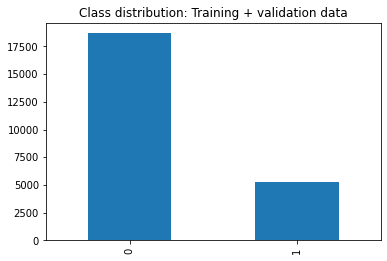

In [6]:
#Make sure the distribution of the dependent variable is the same in both training+validation and test sets.
y_train.value_counts().plot(kind='bar', title='Class distribution: Training + validation data');
y_train.value_counts()    #22% defaulters in the training+validation data

0    4665
1    1328
Name: Default, dtype: int64

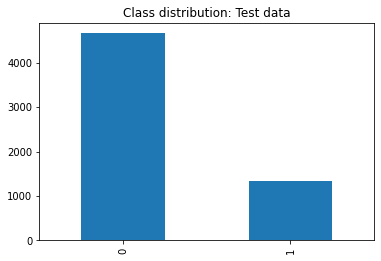

In [7]:
# Test data
y_test.value_counts().plot(kind='bar', title='Class distribution: Test data')
y_test.value_counts() #22% defaulters in the test data

In [8]:
# Scale input variables for training+validation (X_train)
X_train_scaled = preprocessing.MinMaxScaler().fit_transform(X_train)

In [9]:
# Balancing using SMOTE Tomek
X_smt, y_smt = SMOTETomek(random_state=1).fit_sample(X_train_scaled, y_train.squeeze())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [10]:
# #hyperparameter adjustment with GridSearchCV
# #NOTE 1: The 'newton-cg', 'sag', and 'lbfgs' solvers support only L2 regularization or no regularization. The 'liblinear' solver supports both L1 and L2 regularization.
# #NOTE 2: After running this block of code, the results are recorded (last 2 lines of code), and this section is commented to speed up future runs of the notebook where other sections are being updated.
# model = LogisticRegression(random_state=1)

# solver_options = ['newton-cg', 'lbfgs', 'liblinear', 'sag']
# penalty_options = ['l1','l2']
# C_options = [0.1, 0.5, 1, 5, 10, 50, 100]

# param_grid = dict(solver = solver_options, penalty = penalty_options, C = C_options)
# grid = GridSearchCV(model, param_grid, cv=10, scoring = 'f1')
# grid.fit(X_smt,y_smt)
# print (grid.best_params_) # {'C': 50, 'penalty': 'l1', 'solver': 'liblinear'}
# print (grid.best_score_) # output: 0.676

> folds=3, ROC_AUC=0.722 (0.714,0.730)
> folds=5, ROC_AUC=0.723 (0.711,0.734)
> folds=10, ROC_AUC=0.723 (0.699,0.739)
> folds=15, ROC_AUC=0.723 (0.695,0.752)
> folds=20, ROC_AUC=0.723 (0.683,0.761)


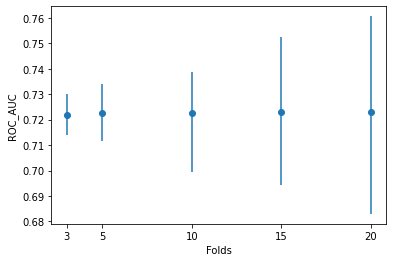

In [ ]:
# Configure the ideal value of K for K-fold cross-validation
# Conclusion: Adding more folds does not seem to affect the performance metric. Use k=10, which is the most commonly used value in literature.
from sklearn.model_selection import KFold
from matplotlib import pyplot

X = df.drop(['Default'], axis=1)
y = df['Default']

model = LogisticRegression(random_state=1, C= 50, penalty= 'l1', solver= 'liblinear')
 
# evaluate the model using a given test condition
def evaluate_model(cv):
	scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv)    # also tested it for accuracy and f1
	return mean(scores), scores.min(), scores.max()

# define folds to test
folds = [3, 5, 10, 15, 20]
# record mean and min/max of each set of results
means, mins, maxs = list(),list(),list()

# evaluate each k value
for k in folds:
	# define the test condition
	cv = KFold(n_splits=k, shuffle=True, random_state=1)
	# evaluate k value
	k_mean, k_min, k_max = evaluate_model(cv)
	# report performance
	print('> folds=%d, ROC_AUC=%.3f (%.3f,%.3f)' % (k, k_mean, k_min, k_max))
	means.append(k_mean)
	mins.append(k_mean - k_min)
	maxs.append(k_max - k_mean)
 
# line plot of k mean values with min/max error bars
fig, ax = plt.subplots()

pyplot.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
plt.xlabel('Folds')
plt.ylabel('ROC_AUC')
ticks = [3,5,10,15,20]
ax.set_xticks(ticks)

pyplot.show()

In [11]:
# Cross_validation using the optimized hyperparameters
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)    #5 repeats of k=10-fold
# create model
model = LogisticRegression(random_state=1, C= 50, penalty= 'l1', solver= 'liblinear')
# evaluate model
scores = cross_val_score(model, X_smt, y_smt, scoring='f1', cv=cv, n_jobs=-1)   # will have 50 scores (5 iterations x 10-folds)
# report performance
print('f1_score: %.3f (%.3f)' % (mean(scores), std(scores)))

f1_score: 0.676 (0.010)


In [12]:
# # #hyperparameter optimization with GridSearchCV for 'elasticnet' penalty with 'saga' solver

# model = LogisticRegression(random_state=1)

# solver_options = ['saga']
# penalty_options = ['elasticnet']
# l1_ratio_options = [0.1, .03, 0.5, 0.7, 0.9]
# C_options = [0.1, 0.5, 1, 5, 10, 50, 100]

# param_grid = dict(solver = solver_options, penalty = penalty_options,l1_ratio = l1_ratio_options, C = C_options)
# grid = GridSearchCV(model, param_grid, cv=10, scoring = 'f1')
# grid.fit(X_smt,y_smt)
# print (grid.best_params_) #{'C': 0.1, 'l1_ratio': 0.03, 'penalty': 'elasticnet', 'solver': 'saga'}
# print (grid.best_score_)  #0.6914246260933862

In [13]:
# Now also try elasticnet penalty with saga solver
# Can also use GridSearchCV  to find the optimal l1_ratio and C for elastic net + saga
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)    #5 repeats of k=10-fold
# create model
model = LogisticRegression(random_state=1, C= 0.1, l1_ratio= 0.03, penalty= 'elasticnet', solver= 'saga')
# evaluate model
scores = cross_val_score(model, X_smt, y_smt, scoring='accuracy', cv=cv, n_jobs=-1)   # will have 50 scores (5 iterations x 10-folds)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.685 (0.008)


In [14]:
#Finally test with the test set (X_test):
# Fit the model
model.fit(X_smt, y_smt)
# Predict using the X_test
X_test_scaled = preprocessing.MinMaxScaler().fit_transform(X_test)
y_pred = model.predict(X_test_scaled)

In [15]:
# performance metrics
cm = confusion_matrix(y_test, y_pred)
print(cm)
print('accuracy', accuracy_score(y_test, y_pred))
print('precision', precision_score(y_test, y_pred))
print('recall', recall_score(y_test, y_pred))

[[4065  600]
 [ 709  619]]
accuracy 0.7815785082596363
precision 0.5077932731747334
recall 0.4661144578313253


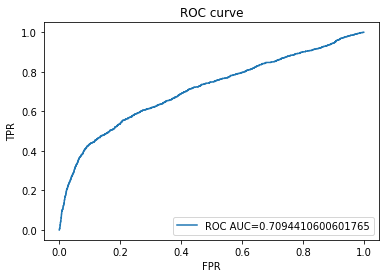

In [16]:
# ROC curve, and ROC AUC
y_pred_proba = model.predict_proba(X_test_scaled)[::,1] 
FPR, TPR, _ = roc_curve(y_test, y_pred_proba)            #roc_curve(y_true, y_score)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(FPR,TPR,label="ROC AUC="+str(auc))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend(loc=4)  
plt.show()

### Now run LR with selected features from XGBoost

In [17]:
#In XGBoost feature importance, top 5 features appeared in the top-10 list for both weight and gain. These features are selected here.
df_selected = df[['AGE', 'LIMIT_BAL', 'Pay_Apr', 'Repay_Sept', 'Pay_Sept','Default' ]]

In [18]:
#Seperate the independent and dependent variables.
df_independent = df_selected.drop(['Default'], axis=1)
df_default = df_selected['Default']

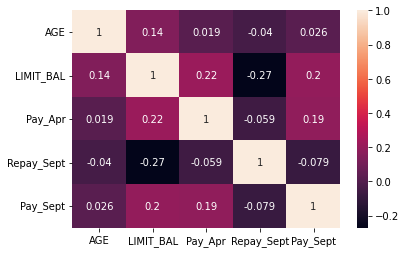

In [19]:
corr_matrix = df_independent.corr()
sns.heatmap(corr_matrix, annot=True);
# there is some correlation. But not a very strong correlation close to +1 or -1.

In [20]:
# split the data into 70% training + 30% test
X_train, X_test, y_train, y_test = train_test_split(df_independent, df_default, test_size=0.30, random_state=1) 

In [21]:
# Scale input variables for training
X_train_scaled = preprocessing.MinMaxScaler().fit_transform(X_train)

In [22]:
# Balancing the training data using SMOTE Tomek
X_smt, y_smt = SMOTETomek(random_state=1).fit_sample(X_train_scaled, y_train.squeeze())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [23]:
# create model
model = LogisticRegression(random_state=1, C= 50, penalty= 'l1', solver= 'liblinear')   #optimized parameters from GridSearchCV
# Fit the model
model.fit(X_smt, y_smt)
# Predict using the X_test
X_test_scaled = preprocessing.MinMaxScaler().fit_transform(X_test)
y_pred = model.predict(X_test_scaled)

In [24]:
# performance metrics
cm = confusion_matrix(y_test, y_pred)
print(cm)
print('accuracy', accuracy_score(y_test, y_pred))
print('precision', precision_score(y_test, y_pred))
print('recall', recall_score(y_test, y_pred))

[[5271 1710]
 [ 829 1180]]
accuracy 0.7175750834260289
precision 0.4083044982698962
recall 0.587356893977103


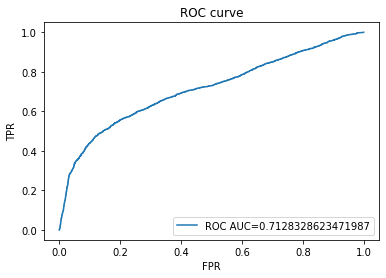

In [25]:
# ROC curve, and ROC AUC
y_pred_proba = model.predict_proba(X_test_scaled)[::,1] 
FPR, TPR, _ = roc_curve(y_test, y_pred_proba)            #roc_curve(y_true, y_score)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(FPR,TPR,label="ROC AUC="+str(auc))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend(loc=4)  
plt.show()

#### Feature selection: Use top-3 features

In [26]:
# looking at Pearson correlations with the dependent variable, and XGBoost feature importance 3 predictors always come up:
df_selected2 = df[['LIMIT_BAL','Repay_Sept', 'Pay_Sept','Default' ]]

In [27]:
#Seperate the independent and dependent variables.
df_independent = df_selected2.drop(['Default'], axis=1)
df_default = df_selected2['Default']

In [28]:
# split the data into 70% training + 30% test
X_train, X_test, y_train, y_test = train_test_split(df_independent, df_default, test_size=0.30, random_state=1) 

In [29]:
# Scale input variables for training
X_train_scaled = preprocessing.MinMaxScaler().fit_transform(X_train)

In [30]:
# Balancing the training data using SMOTE Tomek
X_smt, y_smt = SMOTETomek(random_state=1).fit_sample(X_train_scaled, y_train.squeeze())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [31]:
# create model
model = LogisticRegression(random_state=1, C= 50, penalty= 'l1', solver= 'liblinear')   #optimized parameters from GridSearchCV
# Fit the model
model.fit(X_smt, y_smt)
# Predict using the X_test
X_test_scaled = preprocessing.MinMaxScaler().fit_transform(X_test)
y_pred = model.predict(X_test_scaled)

In [32]:
# performance metrics
cm = confusion_matrix(y_test, y_pred)
print(cm)
print('accuracy', accuracy_score(y_test, y_pred))
print('precision', precision_score(y_test, y_pred))
print('recall', recall_score(y_test, y_pred))
# Insight: can see the performance with these top 3 features is the same as top 5 features

[[5490 1491]
 [ 873 1136]]
accuracy 0.7370411568409344
precision 0.43243243243243246
recall 0.565455450472872


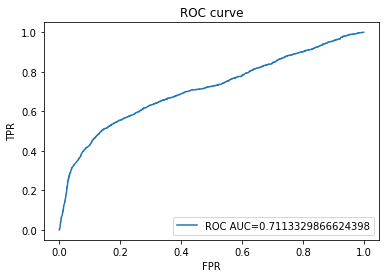

In [33]:
# ROC curve, and ROC AUC
y_pred_proba = model.predict_proba(X_test_scaled)[::,1] 
FPR, TPR, _ = roc_curve(y_test, y_pred_proba)            #roc_curve(y_true, y_score)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(FPR,TPR,label="ROC AUC="+str(auc))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend(loc=4)  
plt.show()